## Содержание

- [Цели исследования](#шаг1)
- [Исследование данных:](#шаг2)
    - [Требуется ли преобразование типов?](#шаг2.1)
    - [Природа пропущенных значений и дубликатов](#шаг2.2)
- [Исследовательский анализ данных:](#шаг3)
    - [Как меняется конверсия в воронке на разных этапах?](#шаг3.1)
    - [Количество событий на пользователя одинаково распределены в выборках?](#шаг3.2)
    - [В выборках встречаются одни и те же пользователи?](#шаг3.3)
    - [Как число событий распределено по дням?](#шаг3.4)
    - [Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?](#шаг3.5)
- [Результаты A/B-тестирования](#шаг4)
- [Выводы](#шаг5)

## Цели исследования<a id='шаг1'></a>

Задача: исследовать эффективность внедрения новой рекомендательной системы.

**Данные:**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Исследование данных:<a id='шаг2'></a>

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

In [2]:
# загрузка данных
try:
    mark = pd.read_csv("/datasets/ab_project_marketing_events.csv")
    ab_new = pd.read_csv("/datasets/final_ab_new_users.csv")
    ev = pd.read_csv("/datasets/final_ab_events.csv")
    part = pd.read_csv("/datasets/final_ab_participants.csv")
except:
    mark = pd.read_csv("datasets/ab_project_marketing_events.csv")
    ab_new = pd.read_csv("datasets/final_ab_new_users.csv")
    ev = pd.read_csv("datasets/final_ab_events.csv")
    part = pd.read_csv("datasets/final_ab_participants.csv")

tables = [mark, ab_new, ev, part]

for t in tables:
    display(t.head())
    t.info()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Данные в целом полные, есть данные о проводимых маркетинговых акциях, зарегистрировавшихся пользователях, событиях пользователей и разделении их на группы теста. Данных для исследования результатов А/В тестирования достаточно.
Пропуски есть только в дополнительном поле `details`, которое по смыслу не всегда заполнено, так что потери данных нет.

### Требуется ли преобразование типов?<a id='шаг2.1'></a>

Преобразования требуют только даты - например, маркетинговых акций и сессий (дата и время).

In [3]:
mark['start_dt'] = pd.to_datetime(mark['start_dt'])
mark['finish_dt'] = pd.to_datetime(mark['finish_dt'])
mark['start_dt_strf'] = mark['start_dt'].dt.strftime('%Y-%m-%d')
mark['finish_dt_strf'] = mark['finish_dt'].dt.strftime('%Y-%m-%d')

ab_new['first_date'] = pd.to_datetime(ab_new['first_date'])
ab_new['first_date_strf'] = ab_new['first_date'].dt.strftime('%Y-%m-%d')

ev['event_dt'] = pd.to_datetime(ev['event_dt'])
ev['event_dt_strf'] = ev['event_dt'].dt.strftime('%Y-%m-%d')

for t in tables:
    display(t.head(1))
    t.info()

,name,regions,start_dt,finish_dt,start_dt_strf,finish_dt_strf
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020-12-25,2021-01-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            14 non-null     object        
 1   regions         14 non-null     object        
 2   start_dt        14 non-null     datetime64[ns]
 3   finish_dt       14 non-null     datetime64[ns]
 4   start_dt_strf   14 non-null     object        
 5   finish_dt_strf  14 non-null     object        
dtypes: datetime64[ns](2), object(4)
memory usage: 800.0+ bytes


,user_id,first_date,region,device,first_date_strf
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          61733 non-null  object        
 1   first_date       61733 non-null  datetime64[ns]
 2   region           61733 non-null  object        
 3   device           61733 non-null  object        
 4   first_date_strf  61733 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.4+ MB


,user_id,event_dt,event_name,details,event_dt_strf
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        440317 non-null  object        
 1   event_dt       440317 non-null  datetime64[ns]
 2   event_name     440317 non-null  object        
 3   details        62740 non-null   float64       
 4   event_dt_strf  440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.8+ MB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


### Природа пропущенных значений и дубликатов<a id='шаг2.2'></a>

Проверка на дубликаты:

In [4]:
mark.duplicated().sum()

0

In [5]:
ab_new.duplicated().sum()

0

In [6]:
ev.duplicated().sum()

0

In [7]:
part.duplicated().sum()

0

Дубликаты отсутствуют

**Проверка неправильных значений:**

- Таблица маркетинговых акций

In [8]:
mark.sort_values(by='start_dt', ascending=False)

,name,regions,start_dt,finish_dt,start_dt_strf,finish_dt_strf
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07,2020-12-30,2021-01-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,2020-11-26,2020-12-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07,2020-10-01,2020-10-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01,2020-06-25,2020-07-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,2020-05-09,2020-05-11
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,2020-04-12,2020-04-19


Всё верно, в таблице действительно содержатся данные о маркетинговых событиях за 2020 год.

- Таблица пользователей, зарегистрировавшихся с 7 по 21 декабря 2020 года.

In [9]:
ab_new.head()

,user_id,first_date,region,device,first_date_strf
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07
1,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,2020-12-07
3,50734A22C0C63768,2020-12-07,EU,iPhone,2020-12-07
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,2020-12-07


Уникальность пользователей:

In [10]:
ab_new.user_id.nunique() == ab_new.shape[0]

True

Проверка значений в колонках `регион` и `устройство`:

In [11]:
ab_new['region'].value_counts()

ab_new['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

Верные значения

- Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [12]:
ev.head()

,user_id,event_dt,event_name,details,event_dt_strf
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


In [13]:
ev['user_id'].value_counts()

A3917F81482141F2    36
426330B820B8711A    32
D6477068EF132236    32
590DACD07A839BC3    32
8AEB716C4CD82CA7    32
                    ..
F7DC611E716A9F76     1
031060788BD3E254     1
9EE380FE30767EA8     1
A7F250AB66BF8AA9     1
812A667823327EDD     1
Name: user_id, Length: 58703, dtype: int64

Типы событий:

In [14]:
ev.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Детали:

In [15]:
ev.groupby('event_name')['details'].value_counts(dropna=False)

event_name    details
login         NaN        189552
product_cart  NaN         62462
product_page  NaN        125563
purchase      4.99        46362
              9.99         9530
              99.99        5631
              499.99       1217
Name: details, dtype: int64

Есть лишь данные о стоимости покупки.

- Таблица участников тестов.

In [16]:
part.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [17]:
# проверка уникальности пользователей:
part.user_id.nunique() == part.shape[0]

part_users = part.user_id.value_counts()
part_users[part_users > 1]

print('{:.1%} пользователей дублируются в группах теста'.format(part_users[part_users > 1].shape[0] / part.shape[0]))

part.group.value_counts()

part.ab_test.value_counts()

8.8% пользователей дублируются в группах теста


interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В данных, которые нам предоставили, оказались данные и другого теста. Отфильтрую его и проверю пересечение пользователей в группах:

In [18]:
part_all = part.copy()
part = part[part.ab_test == 'recommender_system_test']
part.shape

part_users = part.user_id.value_counts()
print('{:.1%} пользователей дублируются в группах нужного нам теста'.format(part_users[part_users > 1].shape[0] / part.shape[0]))

t = part.group.value_counts().to_frame('count')
t['%'] = t['count'] * 100 / t['count'].sum()
t

0.0% пользователей дублируются в группах нужного нам теста


,count,%
A,3824,57.06611
B,2877,42.93389


<a id='дубл'></a>Оказывается, дублирование было лишь за счёт другого теста, пользователи не переходили и их не перемещали из одной группы в другую. Есть некоторый перекос в данных - 57% пользователей находятся в группе А теста, и 43% в группе В.

Проверка соответствия информации о пользователях группам A/B теста.

In [19]:
ev_f = ev[ev['user_id'].isin(part['user_id'])]

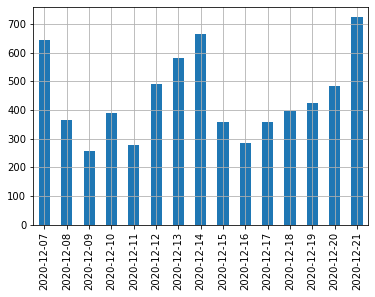

In [20]:
part.merge(ab_new, how='left', on='user_id').first_date_strf.value_counts().sort_index().plot(kind='bar')
plt.grid()
plt.show()

Даты теста соответствуют заявленным.

In [21]:
ab_f = ab_new[(ab_new.region == 'EU')&
             (ab_new['first_date_strf'] >= '2020-12-07') & (ab_new['first_date_strf'] <= '2021-01-04')]

print('Процент пользователей, участвующих в тесте в регионе EU: {:.1%}'.format(part.shape[0]/ ab_new.shape[0]))
print('Количество пользователей, участвующих в тесте: {}'.format(part.shape[0]))

Процент пользователей, участвующих в тесте в регионе EU: 10.9%
Количество пользователей, участвующих в тесте: 6701


По количеству пользователей тест соответствует ТЗ, но в процентном отношении на 4% меньше. Это не критично.

## Исследовательский анализ данных:<a id='шаг3'></a>

### Как меняется конверсия в воронке на разных этапах?<a id='шаг3.1'></a>

In [22]:
_conv = ev_f['event_name'].value_counts()
_conv = _conv.to_frame('count')
_conv['%'] = _conv.iloc[:,0] * 100 / _conv.iloc[0,0]
_conv

,count,%
login,11190,100.000000
product_page,6930,61.930295
purchase,3331,29.767650
product_cart,3247,29.016979


Как видно, на этапе перехода к странице продукта и нажатии на кнопку "купить" "отваливается" по трети от первоначального количества. В корзину переходят почти все из тех, кто решил "купить".

### Количество событий на пользователя одинаково распределены в выборках?<a id='шаг3.2'></a>

In [23]:
# присоединить к таблице событий данные о группах (внутреннее соединение таблиц)
ev_fg = ev_f.merge(part, how='inner', on='user_id')

# данные о количестве пользователей в каждом тесте
ab_count = ev_fg.groupby('group')['user_id'].nunique()

# сортировка по группам теста количества событий
_t = ev_fg.groupby('group')['event_name'].count()
# деление элементов сообразно индексу
events_per_user_by_group = _t / ab_count
events_per_user_by_group = events_per_user_by_group.to_frame('events_per_user')

events_per_user_by_group

,events_per_user
group,
A,7.027303
B,5.812500


**Вывод**: различия есть, но не сильные.

### В выборках встречаются одни и те же пользователи?<a id='шаг3.3'></a>

Нет, выборки [не пересекаются](#дубл)

### Как число событий распределено по дням?<a id='шаг3.4'></a>

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


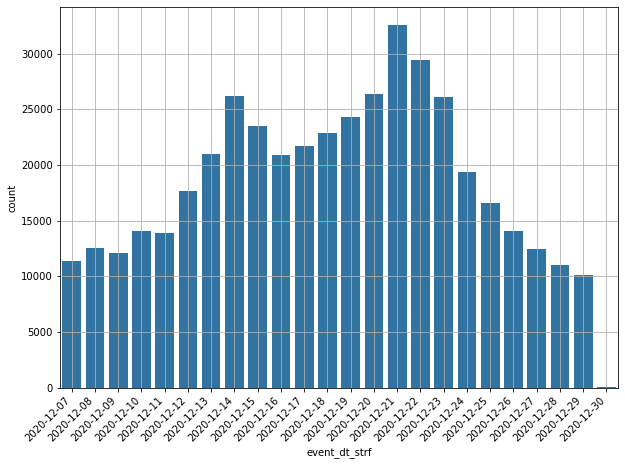

In [24]:
fig, ax = plt.subplots(figsize=(10,7))
ev = ev.sort_values(by='event_dt', ascending=True)
ev['event_dt_strf'] = ev['event_dt'].dt.strftime('%Y-%m-%d')
ev_stat_plot = ev.groupby(['event_dt_strf'])['event_name'].count()
ev_stat_plot = ev_stat_plot.rename('count').reset_index()
sns.barplot(ev_stat_plot['event_dt_strf'], ev_stat_plot['count'], color='tab:blue')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?<a id='шаг3.5'></a>

Соответствие данным ТЗ:

- аудитория: 15% новых пользователей из региона EU - 11%, почти выполнено, не критично.

- ожидаемое количество участников теста: 6000 - выполнено!

Полностью исключить отсутствие маркетинговых событий во время теста мы не можем, достаточно будет иметь группы с одинаковым составом по регионам, чтобы такие события не влияли на одну из групп больше.

In [25]:
mark[mark.regions.str.contains('EU')].sort_values(by='start_dt')

,name,regions,start_dt,finish_dt,start_dt_strf,finish_dt_strf
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2020-05-01,2020-05-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,2020-11-26,2020-12-01
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,2020-12-25,2021-01-03


Во время теста в целевом регионе проходит акция `Christmas&New Year Promo`

In [26]:
users_regions = part.merge(ab_new, how='left', on='user_id')
users_regions_by_group = users_regions.groupby('group')['region'].value_counts()
users_groups_total = users_regions.groupby('group')['user_id'].count()
users_regions_by_group * 100 / users_groups_total

group  region   
A      EU           95.031381
       N.America     3.347280
       APAC          0.967573
       CIS           0.653766
B      EU           94.438651
       N.America     3.302051
       APAC          1.216545
       CIS           1.042753
dtype: float64

Состав групп по регионам практически идентичен.

#### Пересечение с другими тестами:

In [27]:
part_other = part_all[part_all.ab_test != 'recommender_system_test']
users_plus_other_tests_count = (part
.merge(part_other, on='user_id', how='left', suffixes=('','_other'))
.groupby('group')
.ab_test_other
.value_counts())

In [28]:
print('Процент пользователей в каждой группе, участвующих в других тестах:')
users_plus_other_tests_count * 100 / part.groupby('group')['user_id'].nunique()

Процент пользователей в каждой группе, участвующих в других тестах:


group  ab_test_other    
A      interface_eu_test    24.084728
B      interface_eu_test    23.670490
dtype: float64

Различий практически нет, другие тесты не должны влиять на результат текущего.  
**Вывод**: особенности учтены, можно анализировать результаты теста.

## Результаты A/B-тестирования<a id='шаг4'></a>

In [29]:
# разбиение по группам и дням статистики
funnel_by_days = ev_fg.groupby(['event_dt_strf','group'])['event_name'].value_counts()
funnel_by_days = funnel_by_days.to_frame('count').reset_index()
funnel_by_days_max = funnel_by_days.groupby(['event_dt_strf','group'])['count'].max().to_frame('max_count').reset_index()
funnel_by_days = funnel_by_days.merge(funnel_by_days_max, how='left', on=['event_dt_strf', 'group'])
funnel_by_days['%'] = funnel_by_days['count'] * 100 / funnel_by_days['max_count']
funnel_by_days.head()

,event_dt_strf,group,event_name,count,max_count,%
0,2020-12-07,A,login,154,154,100.000000
1,2020-12-07,A,product_page,96,154,62.337662
2,2020-12-07,A,purchase,46,154,29.870130
3,2020-12-07,A,product_cart,35,154,22.727273
4,2020-12-07,B,login,165,165,100.000000


In [30]:
# считаю воронку по каждому дню и группе
funnel_count = (funnel_by_days
.set_index(['event_dt_strf','group', 'event_name'])[['count']]
.unstack(level='event_name', fill_value=0)
.reset_index())
funnel_count.columns = ['event_dt_dtrf', 'group', 'login', 'product_cart', 'product_page', 'purchase']
funnel_count.head()
funnel_count_cumulative = (
    funnel_count
    .sort_values(by=['event_dt_dtrf','group'])
)

funnel_count_columns = ['login', 'product_cart', 'product_page', 'purchase']

funnel_count_cumulative[['login', 'product_cart', 'product_page', 'purchase']] = \
funnel_count_cumulative.groupby('group')[['login', 'product_cart', 'product_page', 'purchase']].cumsum()

funnel_count_cumulative_pct = funnel_count_cumulative.copy()
for col in funnel_count_columns:
    funnel_count_cumulative_pct[col] = funnel_count_cumulative[col] * 100 / funnel_count_cumulative['login']
funnel_count_cumulative_pct.head()

,event_dt_dtrf,group,login,product_cart,product_page,purchase
0,2020-12-07,A,100.0,22.727273,62.337662,29.870130
1,2020-12-07,B,100.0,27.878788,65.454545,35.757576
2,2020-12-08,A,100.0,23.003195,65.175719,26.517572
3,2020-12-08,B,100.0,28.169014,60.563380,33.098592
4,2020-12-09,A,100.0,24.847251,63.136456,27.291242


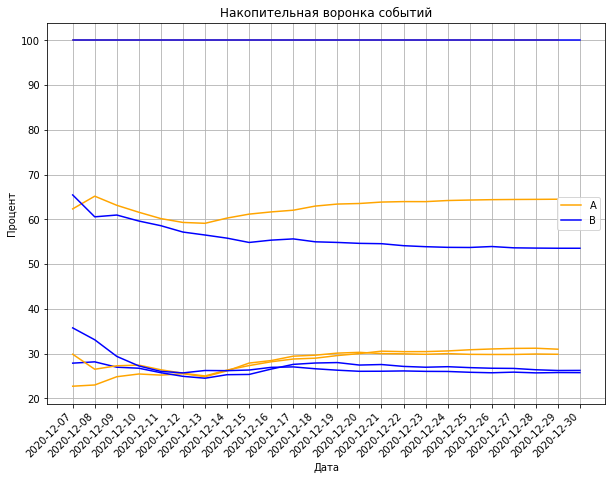

In [31]:
import numpy as np
def plot_AB(A, B, ycol, ax, title='', ylabel='', ls='-', ymin=None, ymax=None):
    """Отобразить график распределения для А/В теста
    ycol - колонка, для оси у
    """
    ax.plot(A.event_dt_dtrf, A[ycol], ls, label='A', color='orange')
    ax.plot(B.event_dt_dtrf, B[ycol], ls, label='B', color='blue')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(ylabel)
    plt.xlabel('Дата')
    if np.logical_and(pd.notna(ymin), pd.notna(ymax)):
        plt.ylim((ymin, ymax))
    ax.grid()

_, ax = plt.subplots(figsize=(10,7))
plt.grid()
A = funnel_count_cumulative_pct[funnel_count_cumulative_pct['group'] == 'A']
B = funnel_count_cumulative_pct[funnel_count_cumulative_pct['group'] == 'B']
for col in ['login', 'product_cart', 'product_page', 'purchase']:
    plot_AB(A, B, col, title='Накопительная воронка событий', ylabel='Процент', ax=ax)
plt.legend(['A','B'])
plt.show()

#### Вычисление относительной конверсии.

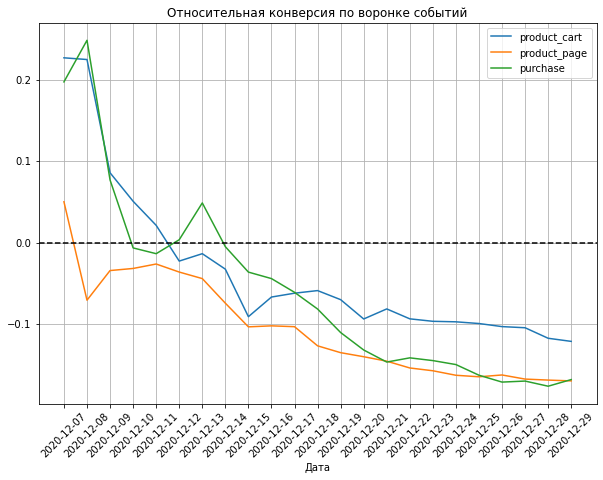

In [32]:
def plot_rel_AB(funnel_count_A, funnel_count_B, col, title='', ylabel='', second_hline=None, second_AB=None):
    _, ax = plt.subplots(figsize=(10, 7))
    _A = funnel_count_A.set_index('event_dt_dtrf')
    _B = funnel_count_B.set_index('event_dt_dtrf')
    cols = ['product_cart', 'product_page', 'purchase']
    _funnel_rel = _A.copy()
    for col in cols:
        _funnel_rel[col] = _B[col] / _A[col] - 1
    lines = []
    for col in cols:
        l, = plt.plot(_funnel_rel.index.tolist(), _funnel_rel[col])
        lines.append(l)
    plt.axhline(0, ls='--', color='black')
    plt.legend(handles=lines, labels=cols)
    if pd.notna(second_hline):
        plt.axhline(second_hline, ls='--', linewidth=1, color='black')

    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

plot_rel_AB(A, B, col, title='Относительная конверсия по воронке событий', ylabel='', second_hline=None, second_AB=None)

#### Анализ данных по дням:

In [33]:
ev_fg['date'] = ev_fg.event_dt.astype('datetime64[D]')

In [34]:
users_stat_by_group_and_date = (ev_fg
        .groupby(['group','date'])
        .user_id
        .nunique()
        .rename('users')
        .reset_index())

In [35]:
def plot_AB(A, B, ycol, title='', ylabel='', ls='-', ymin=None, ymax=None):
    """Отобразить график распределения для А/В теста
    ycol - колонка, для оси у
    """
    _, ax = plt.subplots(figsize=(10,7))
    plt.plot(A.date, A[ycol], ls, label='A')
    plt.plot(B.date, B[ycol], ls, label='B')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel)
    plt.xlabel('Дата')
    if np.logical_and(pd.notna(ymin), pd.notna(ymax)):
        plt.ylim((ymin, ymax))
    plt.grid()
    plt.legend()
    plt.show()

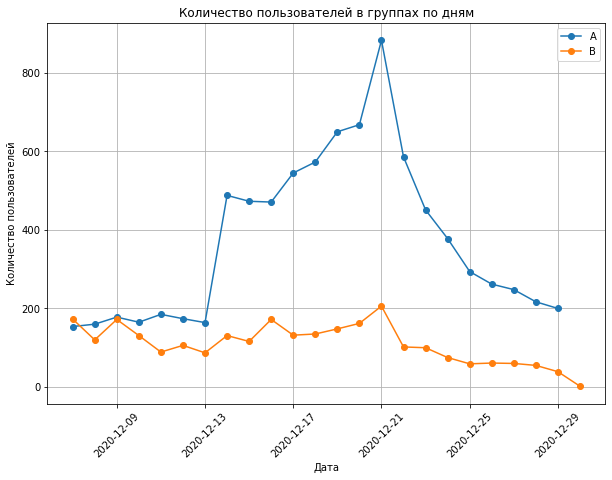

In [36]:
users_A = users_stat_by_group_and_date[users_stat_by_group_and_date.group == 'A']
users_B = users_stat_by_group_and_date[users_stat_by_group_and_date.group == 'B']
plot_AB(users_A, users_B, 'users', title='Количество пользователей в группах по дням',
        ylabel='Количество пользователей', ls='-o')

In [37]:
# количество данных в группах по дням
users_stat_by_group_and_date.group.value_counts()

B    24
A    23
Name: group, dtype: int64

##### Таблица с заказами:

In [38]:
users_stat = (ev_fg
 .groupby(['group','date'])
 .agg({
     'user_id':'nunique',
      }, axis=1)
 .rename({'user_id':'users'},axis=1)
 .reset_index()
)

purchases_stat = (ev_fg[ev_fg.event_name == 'purchase']
 .groupby(['date','group'])
 .agg({'user_id':'count',
      'details':'sum'}, axis=1)
 .rename({'user_id':'purchases',
         'details':'revenue'}, axis=1)
 .reset_index()
)
groups_stat = users_stat.merge(purchases_stat, on=['date','group'], how='left')

In [39]:
groups_stat.head()

,group,date,users,purchases,revenue
0,A,2020-12-07,154,46.0,1214.54
1,A,2020-12-08,160,37.0,779.63
2,A,2020-12-09,178,51.0,1369.49
3,A,2020-12-10,165,46.0,1329.54
4,A,2020-12-11,185,42.0,1099.58


In [40]:
groups_stat_A = groups_stat[groups_stat.group == 'A']
groups_stat_B = groups_stat[groups_stat.group == 'B']

Распределение по дням для purchases


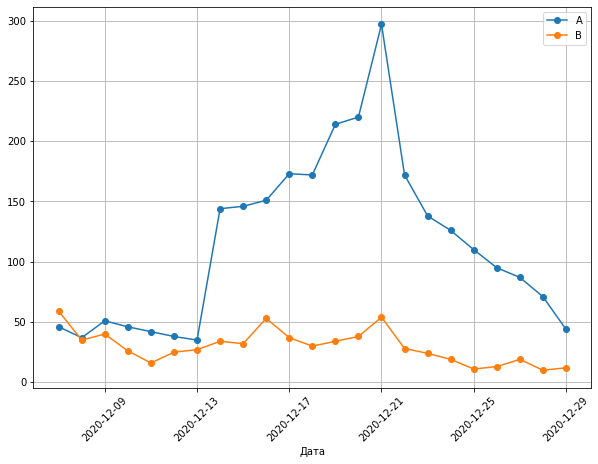

Распределение по дням для users


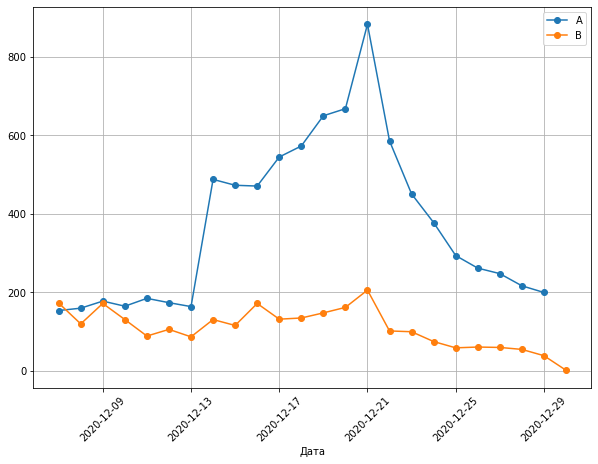

Распределение по дням для revenue


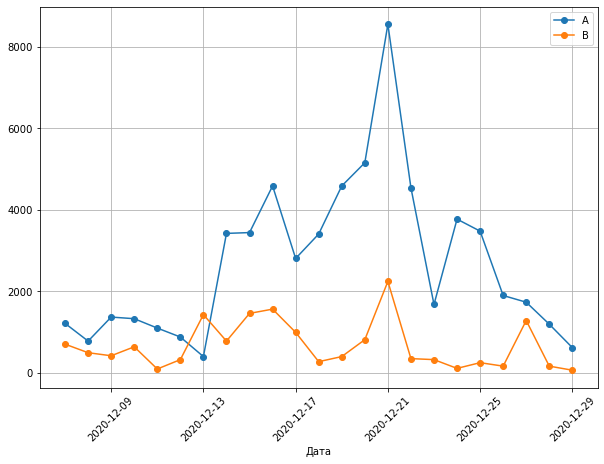

In [41]:
for col in ['purchases', 'users', 'revenue']:

    print('Распределение по дням для', col)
    plot_AB(groups_stat_A, groups_stat_B, ycol=col, ls='-o')

#### Подготовка данных

In [42]:
def get_data_events(users, events):
# агрегация обычных и кумулятивных данных
    users_a_daily = users[users['group']=='A'][['date', 'users']]
    users_a_daily.columns = ['date', 'users_per_date_a']

    users_a_cumulative = users_a_daily.apply(lambda x: users_a_daily[users_a_daily['date'] <= x['date']].agg({'date' : 'max', 'users_per_date_a' : 'sum'}), axis=1)
    users_a_cumulative.columns = ['date', 'users_cumulative_a']

    users_b_daily = users[users['group']=='B'][['date', 'users']]
    users_b_daily.columns = ['date', 'users_per_date_b']

    users_b_cumulative = users_b_daily.apply(lambda x: users_b_daily[users_b_daily['date'] <= x['date']].agg({'date' : 'max', 'users_per_date_b' : 'sum'}), axis=1)
    users_b_cumulative.columns = ['date', 'users_cumulative_b']

    events_a_daily = events[events['group']=='A'][['date', 'transaction_id', 'visitor_id', 'event_name']]\
        .groupby('date', as_index=False)\
        .agg({'transaction_id' : pd.Series.nunique, 'event_name' : 'count'})
    events_a_daily.columns = ['date', 'events_per_date_a', 'count_per_date_a']

    events_a_cumulative = events_a_daily.apply(
        lambda x: \
            events_a_daily[events_a_daily['date'] <= x['date']]\
                .agg({
                    'date' : 'max',
                    'events_per_date_a' : 'sum',
                    'count_per_date_a' : 'sum'}), axis=1).sort_values(by=['date'])
    events_a_cumulative.columns = ['date', 'events_cumulative_a', 'count_cumulative_a']

    events_b_daily = events[events['group']=='B'][['date', 'transaction_id', 'visitor_id', 'event_name']]\
        .groupby('date', as_index=False)\
        .agg({'transaction_id' : pd.Series.nunique, 'event_name' : 'count'})
    events_b_daily.columns = ['date', 'events_per_date_b', 'count_per_date_b']

    events_b_cumulative = events_b_daily.apply(
        lambda x: \
            events_b_daily[events_b_daily['date'] <= x['date']]\
                .agg({
                    'date' : 'max',
                    'events_per_date_b' : 'sum',
                    'count_per_date_b' : 'sum'}), axis=1).sort_values(by=['date'])
    events_b_cumulative.columns = ['date', 'events_cumulative_b', 'count_cumulative_b']

    data = events_a_daily.merge(events_b_daily, left_on='date', right_on='date', how='left')\
        .merge(events_a_cumulative, left_on='date', right_on='date', how='left')\
        .merge(events_b_cumulative, left_on='date', right_on='date', how='left')\
        .merge(users_a_daily, left_on='date', right_on='date', how='left')\
        .merge(users_b_daily, left_on='date', right_on='date', how='left')\
        .merge(users_a_cumulative, left_on='date', right_on='date', how='left')\
        .merge(users_b_cumulative, left_on='date', right_on='date', how='left')
    data.head()
    return data

def get_data(users, purchases):
# агрегация обычных и кумулятивных данных
    users_a_daily = users[users['group']=='A'][['date', 'users']]
    users_a_daily.columns = ['date', 'users_per_date_a']

    users_a_cumulative = users_a_daily.apply(lambda x: users_a_daily[users_a_daily['date'] <= x['date']].agg({'date' : 'max', 'users_per_date_a' : 'sum'}), axis=1)
    users_a_cumulative.columns = ['date', 'users_cumulative_a']

    users_b_daily = users[users['group']=='B'][['date', 'users']]
    users_b_daily.columns = ['date', 'users_per_date_b']

    users_b_cumulative = users_b_daily.apply(lambda x: users_b_daily[users_b_daily['date'] <= x['date']].agg({'date' : 'max', 'users_per_date_b' : 'sum'}), axis=1)
    users_b_cumulative.columns = ['date', 'users_cumulative_b']

    purchases_a_daily = purchases[purchases['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
        .groupby('date', as_index=False)\
        .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
    purchases_a_daily.columns = ['date', 'purchases_per_date_a', 'revenue_per_date_a']

    purchases_a_cumulative = purchases_a_daily.apply(
        lambda x: \
            purchases_a_daily[purchases_a_daily['date'] <= x['date']]\
                .agg({
                    'date' : 'max',
                    'purchases_per_date_a' : 'sum',
                    'revenue_per_date_a' : 'sum'}), axis=1).sort_values(by=['date'])
    purchases_a_cumulative.columns = ['date', 'purchases_cumulative_a', 'revenue_cumulative_a']

    purchases_b_daily = purchases[purchases['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
        .groupby('date', as_index=False)\
        .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
    purchases_b_daily.columns = ['date', 'purchases_per_date_b', 'revenue_per_date_b']

    purchases_b_cumulative = purchases_b_daily.apply(
        lambda x: \
            purchases_b_daily[purchases_b_daily['date'] <= x['date']]\
                .agg({
                    'date' : 'max',
                    'purchases_per_date_b' : 'sum',
                    'revenue_per_date_b' : 'sum'}), axis=1).sort_values(by=['date'])
    purchases_b_cumulative.columns = ['date', 'purchases_cumulative_b', 'revenue_cumulative_b']

    data = purchases_a_daily.merge(purchases_b_daily, left_on='date', right_on='date', how='left')\
        .merge(purchases_a_cumulative, left_on='date', right_on='date', how='left')\
        .merge(purchases_b_cumulative, left_on='date', right_on='date', how='left')\
        .merge(users_a_daily, left_on='date', right_on='date', how='left')\
        .merge(users_b_daily, left_on='date', right_on='date', how='left')\
        .merge(users_a_cumulative, left_on='date', right_on='date', how='left')\
        .merge(users_b_cumulative, left_on='date', right_on='date', how='left')
    data.head()
    return data

In [43]:
purchases = (ev_fg[ev_fg.event_name == 'purchase']
             .rename({'user_id':'visitor_id','event_dt':'transaction_id','details':'revenue'}, axis=1))
product_carts = (ev_fg[ev_fg.event_name == 'product_cart']
             .rename({'user_id':'visitor_id','event_dt':'transaction_id'}, axis=1))
product_pages = (ev_fg[ev_fg.event_name == 'product_page']
             .rename({'user_id':'visitor_id','event_dt':'transaction_id'}, axis=1))

In [44]:
# исходные и кумулятивные данные в одной таблице по просмотру страницы товара и корзины перед покупкой
conv_data_product_cart = get_data_events(users_stat_by_group_and_date, product_carts)
conv_data_product_page = get_data_events(users_stat_by_group_and_date, product_pages)

In [45]:
# исходные и кумулятивные данные в одной таблице
data = get_data(users_stat_by_group_and_date, purchases)

In [46]:
display(data.head())
data.info()

,date,purchases_per_date_a,revenue_per_date_a,purchases_per_date_b,revenue_per_date_b,purchases_cumulative_a,revenue_cumulative_a,purchases_cumulative_b,revenue_cumulative_b,users_per_date_a,users_per_date_b,users_cumulative_a,users_cumulative_b
0,2020-12-07,45,1214.54,59,704.41,45,1214.54,59,704.41,154,173,154,173
1,2020-12-08,37,779.63,35,494.65,82,1994.17,94,1199.06,160,120,314,293
2,2020-12-09,51,1369.49,40,419.60,133,3363.66,134,1618.66,178,172,492,465
3,2020-12-10,46,1329.54,26,639.74,179,4693.20,160,2258.40,165,131,657,596
4,2020-12-11,42,1099.58,16,94.84,221,5792.78,176,2353.24,185,89,842,685


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    23 non-null     datetime64[ns]
 1   purchases_per_date_a    23 non-null     int64         
 2   revenue_per_date_a      23 non-null     float64       
 3   purchases_per_date_b    23 non-null     int64         
 4   revenue_per_date_b      23 non-null     float64       
 5   purchases_cumulative_a  23 non-null     int64         
 6   revenue_cumulative_a    23 non-null     float64       
 7   purchases_cumulative_b  23 non-null     int64         
 8   revenue_cumulative_b    23 non-null     float64       
 9   users_per_date_a        23 non-null     int64         
 10  users_per_date_b        23 non-null     int64         
 11  users_cumulative_a      23 non-null     int64         
 12  users_cumulative_b      23 non-null     int64       

## Проанализирую A/B-тест:

#### <a id='шаг2.6'></a>Определю наличие выбросов для заказов пользователей

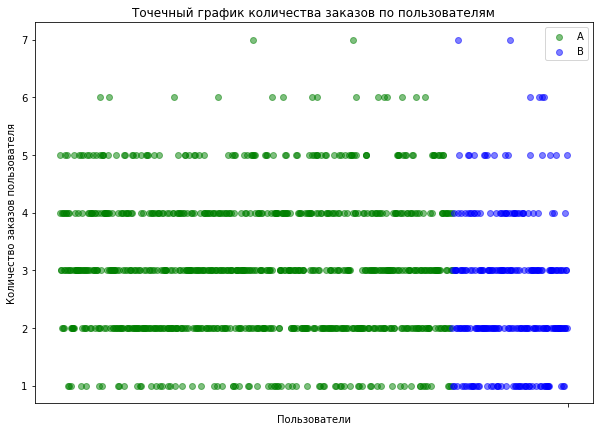

In [47]:
_, ax = plt.subplots(figsize=(10,7))
users_purchases_num_A = purchases[purchases.group=='A'].groupby('visitor_id')['transaction_id'].nunique()
plt.scatter(users_purchases_num_A.index, users_purchases_num_A, color='green', label='A', alpha=0.5)
users_purchases_num_B = purchases[purchases.group=='B'].groupby('visitor_id')['transaction_id'].nunique()
plt.scatter(users_purchases_num_B.index, users_purchases_num_B, color='blue', label='B', alpha=0.5)
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов пользователя')
plt.xlabel('Пользователи')
plt.xticks('')
plt.legend()
plt.show()

Вывод: состав групп по характеру покупок одинаковый - не более 7 шт. Фильтрация не требуется.

#### <a id='шаг2.8'></a>Распределение стоимости заказов на пользователя

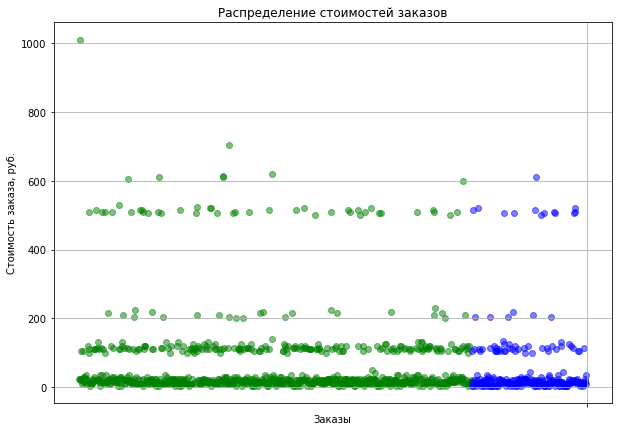

In [48]:
_, ax = plt.subplots(figsize=(10,7))
users_purchases_num_A = purchases[purchases.group=='A'].groupby('visitor_id')['revenue'].sum()
plt.scatter(users_purchases_num_A.index, users_purchases_num_A, color='green', label='A', alpha=0.5)
users_purchases_num_B = purchases[purchases.group=='B'].groupby('visitor_id')['revenue'].sum()
plt.scatter(users_purchases_num_B.index, users_purchases_num_B, color='blue', label='B', alpha=0.5)
plt.title('Все данные')
plt.xlabel('Заказы')
plt.xticks('')
plt.ylabel('Стоимость заказа, руб.')
plt.title('Распределение стоимостей заказов')
plt.grid()
plt.show()

Вывод: заказы стоимостью до 1000 рублей, аномальных нет.

#### <a id='шаг2.1'></a> Построю график кумулятивной выручки по группам

In [49]:
def get_cumulative_data_AB(data):
    cumulative_A = data[['date', 
                         'revenue_cumulative_a',
                         'purchases_cumulative_a',
                        'users_cumulative_a']].rename(columns={'revenue_cumulative_a': 'revenue_cumulative',
                                                                  'purchases_cumulative_a': 'purchases_cumulative',
                                                                 'users_cumulative_a': 'users_cumulative'})
    cumulative_B = data[['date', 
                         'revenue_cumulative_b',
                         'purchases_cumulative_b',
                         'users_cumulative_b'
                        ]].rename(columns={'revenue_cumulative_b': 'revenue_cumulative',
                                           'purchases_cumulative_b': 'purchases_cumulative',
                                          'users_cumulative_b': 'users_cumulative'})
    cumulative_A['mean_check_cumulative'] = cumulative_A.revenue_cumulative / cumulative_A.purchases_cumulative
    cumulative_B['mean_check_cumulative'] = cumulative_B.revenue_cumulative / cumulative_B.purchases_cumulative
    cumulative_A['conversion_cumulative'] = cumulative_A.purchases_cumulative / cumulative_A.users_cumulative
    cumulative_B['conversion_cumulative'] = cumulative_B.purchases_cumulative / cumulative_B.users_cumulative
    print('Первые строки таблицы накопительных данных группы А')
    display(cumulative_A.head())
    print('Первые строки таблицы накопительных данных группы В')
    display(cumulative_B.head())
    return cumulative_A, cumulative_B

In [50]:
cumulative_A, cumulative_B = get_cumulative_data_AB(data)

Первые строки таблицы накопительных данных группы А


,date,revenue_cumulative,purchases_cumulative,users_cumulative,mean_check_cumulative,conversion_cumulative
0,2020-12-07,1214.54,45,154,26.989778,0.292208
1,2020-12-08,1994.17,82,314,24.319146,0.261146
2,2020-12-09,3363.66,133,492,25.290677,0.270325
3,2020-12-10,4693.20,179,657,26.218994,0.272451
4,2020-12-11,5792.78,221,842,26.211674,0.262470


Первые строки таблицы накопительных данных группы В


,date,revenue_cumulative,purchases_cumulative,users_cumulative,mean_check_cumulative,conversion_cumulative
0,2020-12-07,704.41,59,173,11.939153,0.341040
1,2020-12-08,1199.06,94,293,12.755957,0.320819
2,2020-12-09,1618.66,134,465,12.079552,0.288172
3,2020-12-10,2258.40,160,596,14.115000,0.268456
4,2020-12-11,2353.24,176,685,13.370682,0.256934


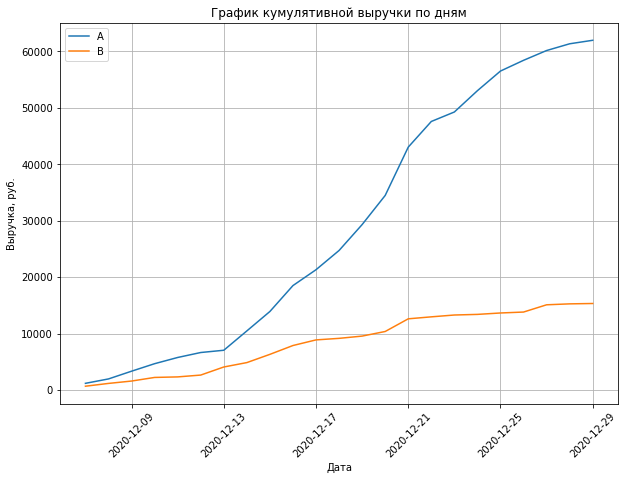

In [51]:
plot_AB(cumulative_A, cumulative_B, 'revenue_cumulative', title='График кумулятивной выручки по дням',
       ylabel='Выручка, руб.')

**Вывод:** по кумулятивной выручке контрольная группа А значительно превосходит В.

#### <a id='шаг2.2'></a>Построю график кумулятивного среднего чека по группам. Сделаю выводы и предположения.

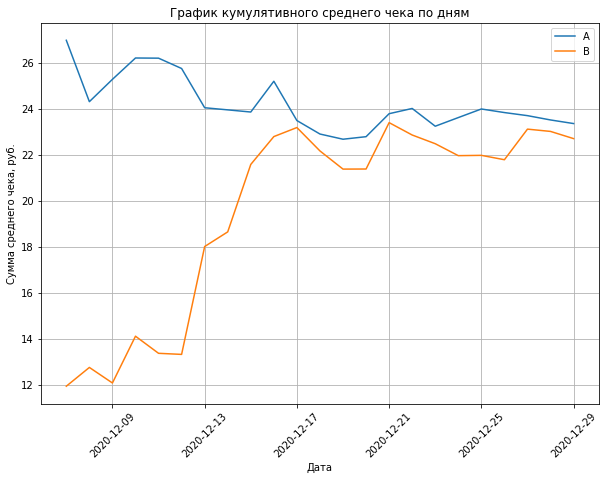

In [52]:
plot_AB(cumulative_A, cumulative_B, 'mean_check_cumulative', title='График кумулятивного среднего чека по дням',
       ylabel='Сумма среднего чека, руб.')

Вывод: средний чек выровнялся на отметке 23 рубля.

#### <a id='шаг2.3'></a>Построю график относительного изменения кумулятивного среднего чека группы B к группе A

In [53]:
def get_rel_col(A, B, col):
    both = A[['date', col]].merge(B[['date', col]],
                                                                 on='date', how='outer',
                                                                 suffixes=('_A', '_B'))
    print('Проверка на пропуски после соединения таблиц:')
    display(both.isnull().sum())
    rel_col_name = 'rel_' + col
    col_A = col + '_A'
    col_B = col + '_B'
    both[rel_col_name] = both[col_B] / both[col_A] - 1
    display(both.head())
    return both

In [54]:
cumulative_both_mean_check = get_rel_col(cumulative_A, cumulative_B, 'mean_check_cumulative')

Проверка на пропуски после соединения таблиц:


date                       0
mean_check_cumulative_A    0
mean_check_cumulative_B    0
dtype: int64

,date,mean_check_cumulative_A,mean_check_cumulative_B,rel_mean_check_cumulative
0,2020-12-07,26.989778,11.939153,-0.557642
1,2020-12-08,24.319146,12.755957,-0.475477
2,2020-12-09,25.290677,12.079552,-0.522371
3,2020-12-10,26.218994,14.115000,-0.461650
4,2020-12-11,26.211674,13.370682,-0.489896


In [55]:
def plot_rel_AB(AB, col, title='', ylabel='', second_hline=None, second_AB=None):
    _, ax = plt.subplots(figsize=(10, 7))
    l1, = plt.plot(AB['date'], AB[col])
    plt.axhline(0, ls='--', color='black')
    if type(second_AB) == pd.DataFrame:
        l2, = plt.plot(second_AB['date'], second_AB[col], ls='--')
        plt.legend(handles=(l1, l2), labels=('Отфильтрованные данные', 'Исходные данные'))
    if pd.notna(second_hline):
        plt.axhline(second_hline, ls='--', linewidth=1, color='black')

    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

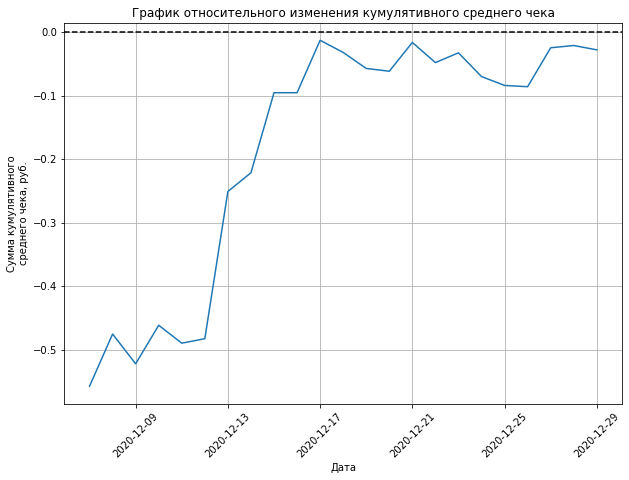

In [56]:
plot_rel_AB(cumulative_both_mean_check, 'rel_mean_check_cumulative',
            title='График относительного изменения кумулятивного среднего чека',
            ylabel='Сумма кумулятивного\nсреднего чека, руб.')

Вывод: график к концу теста не вполне выровнялся, но скорее всего отличий по кумулятивному среднему чеку между группами не будет.

#### <a id='шаг2.4'></a>Построю график кумулятивной конверсии по группам

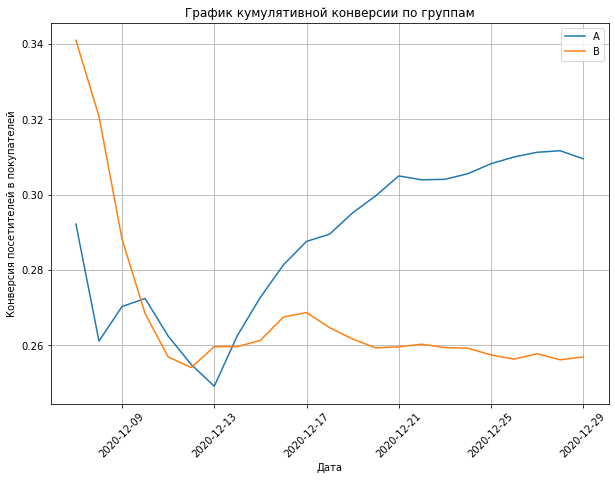

In [57]:
plot_AB(cumulative_A, cumulative_B, 'conversion_cumulative', title='График кумулятивной конверсии по группам',
       ylabel='Конверсия посетителей в покупателей')

Вывод: видно, что накопительная конверсия начиная с 21 декабря почти выровнялась, со значением 0.31 для группы А против 0.26 для группы В.

#### <a id='шаг2.5'></a>Построю график относительного изменения кумулятивной конверсии группы B к группе A

In [58]:
cumulative_both_conv = get_rel_col(cumulative_A, cumulative_B, 'conversion_cumulative')

Проверка на пропуски после соединения таблиц:


date                       0
conversion_cumulative_A    0
conversion_cumulative_B    0
dtype: int64

,date,conversion_cumulative_A,conversion_cumulative_B,rel_conversion_cumulative
0,2020-12-07,0.292208,0.341040,0.167116
1,2020-12-08,0.261146,0.320819,0.228502
2,2020-12-09,0.270325,0.288172,0.066020
3,2020-12-10,0.272451,0.268456,-0.014660
4,2020-12-11,0.262470,0.256934,-0.021092


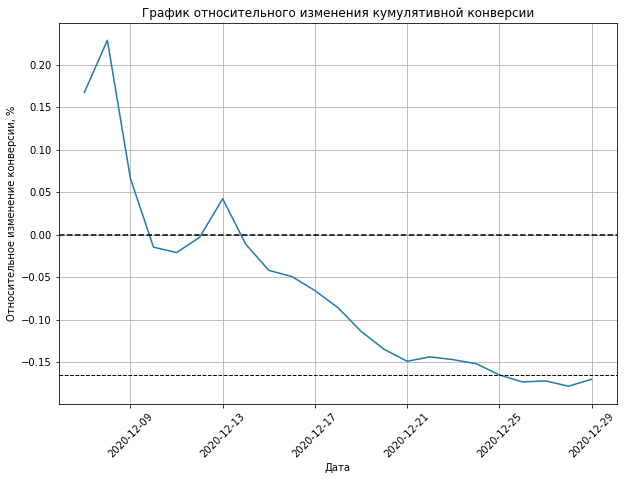

In [59]:
plot_rel_AB(cumulative_both_conv, 'rel_conversion_cumulative', title='График относительного изменения кумулятивной конверсии',
           ylabel='Относительное изменение конверсии, %', second_hline=-0.165)

Вывод: относительное изменение кумулятивной конверсии установилось где-то на уровне -0.165, группа В проигрывает контрольной.

#### <a id='шаг2.10'></a>Посчитаю статистическую значимость различий в конверсии между группами

Сформулирую гипотезы:
- Н0: различий в конверсии между группами А и В нет
- Н1: различия в конверсии есть

Alpha - стандартно, 5%.

Использую устойчивый к выбросам тест Манна-Уитни:

In [60]:
# конверсия просмотра страницы товара
count_by_users_a_pages = (product_pages[product_pages['group']=='A']
                    .groupby('visitor_id', as_index=False)
                    .agg({'event_name' : 'count'}))
count_by_users_a_pages.columns = ['visitor_id', 'event_count']

count_by_users_b_pages = (product_pages[product_pages['group']=='B']
                    .groupby('visitor_id', as_index=False)
                    .agg({'event_name' : 'count'}))
count_by_users_b_pages.columns = ['visitor_id', 'event_count']

sample_a_pages = (pd.concat([count_by_users_a_pages['event_count'],
                       pd.Series(0, index=np.arange(conv_data_product_page['users_per_date_a'].sum() -\
                                                    len(count_by_users_a_pages['event_count'])),
                                 name='event_count')],axis=0))

sample_b_pages = (pd.concat([count_by_users_b_pages['event_count'],
                       pd.Series(0, index=np.arange(conv_data_product_page['users_per_date_b'].sum() -\
                                                    len(count_by_users_b_pages['event_count'])),
                                 name='event_count')],
                      axis=0))
print('Конверсия в просмотры страницы товара:')
print("p-value: {0:.3f}".format(st.mannwhitneyu(sample_a_pages, sample_b_pages)[1]))

print("Относительная конверсия В/А: {0:.3f}".format(sample_b_pages.mean()/sample_a_pages.mean()-1)) 

Конверсия в просмотры страницы товара:
p-value: 0.028
Относительная конверсия В/А: -0.172


In [61]:
# конверсия в переходы в корзину
count_by_users_a_carts = (product_carts[product_carts['group']=='A']
                    .groupby('visitor_id', as_index=False)
                    .agg({'event_name' : 'count'}))
count_by_users_a_carts.columns = ['visitor_id', 'event_count']

count_by_users_b_carts = (product_carts[product_carts['group']=='B']
                    .groupby('visitor_id', as_index=False)
                    .agg({'event_name' : 'count'}))
count_by_users_b_carts.columns = ['visitor_id', 'event_count']

sample_a_carts = (pd.concat([count_by_users_a_carts['event_count'],
                       pd.Series(0, index=np.arange(conv_data_product_cart['users_per_date_a'].sum() -\
                                                    len(count_by_users_a_carts['event_count'])),
                                 name='event_count')],axis=0))

sample_b_carts = (pd.concat([count_by_users_b_carts['event_count'],
                       pd.Series(0, index=np.arange(conv_data_product_cart['users_per_date_b'].sum() -\
                                                    len(count_by_users_b_carts['event_count'])),
                                 name='event_count')],
                      axis=0))
print('Конверсия в переходы в корзину:')
print("p-value: {0:.3f}".format(st.mannwhitneyu(sample_a_carts, sample_b_carts)[1]))

print("Относительная конверсия В/А: {0:.3f}".format(sample_b_carts.mean()/sample_a_carts.mean()-1)) 

Конверсия в переходы в корзину:
p-value: 0.434
Относительная конверсия В/А: -0.123


In [62]:
# отличия в количестве заказов по пользователям
purchases_by_users_a = (purchases[purchases['group']=='A']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id' : pd.Series.nunique}))
purchases_by_users_a.columns = ['visitor_id', 'purchases']

purchases_by_users_b = (purchases[purchases['group']=='B']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id' : pd.Series.nunique}))
purchases_by_users_b.columns = ['visitor_id', 'purchases']

sample_a = (pd.concat([purchases_by_users_a['purchases'],
                       pd.Series(0, index=np.arange(data['users_per_date_a'].sum() -\
                                                    len(purchases_by_users_a['purchases'])),
                                 name='purchases')],axis=0))

sample_b = (pd.concat([purchases_by_users_b['purchases'],
                       pd.Series(0, index=np.arange(data['users_per_date_b'].sum() -\
                                                    len(purchases_by_users_b['purchases'])),
                                 name='purchases')],
                      axis=0))

print("p-value: {0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

print("Относительная конверсия В/А: {0:.3f}".format(sample_b.mean()/sample_a.mean()-1)) 

p-value: 0.170
Относительная конверсия В/А: -0.171


Вывод: статистически значимое различие в конверсии есть только по просмотру карточки товара. Если новая продуктовая воронка допустила там значительные изменения, их стоит отменить.

#### <a id='шаг2.11'></a>Посчитаю статистическую значимость различий в среднем чеке заказа между группами

Применю так же тест, устойчивый к выбросам, Манна-Уитни.
За нулевую гипотезу принимаю, что выборки взяты из одной генеральной совокупности, за первую - из разных.  
alpha принимаю за 5%.

Относительные различия в среднем чеке между группами.

In [63]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(purchases[purchases['group']=='A']['revenue'], purchases[purchases['group']=='B']['revenue'])[1]))
print("Относительная величина различий средних чеков, В/А: {0:.3f}".format(purchases[purchases['group']=='B']['revenue'].mean()/purchases[purchases['group']=='A']['revenue'].mean()-1))

p-value: 0.342
Относительная величина различий средних чеков, В/А: -0.027


Вывод: по среднему чеку значимых отличий между группами нет.

## Выводы<a id='шаг5'></a>  

Для анализа предоставлены данные о:
- маркетинговых событиях,
- новых пользователях за период
- событиях пользователей
- группах проводимых тестов

Данные предобработаны, приведены к нужному типу.

Данные о событиях прерываются начиная с 30 декабря, и по 4 января данных нет. Продолжил анализ, чтобы понять, хватит ли данных для принятия решения по A/B тесту.

Были отфильтрованы события, не относящиеся к тесту, проверено соответствие групп заявленным в ТЗ требованиям:
- количество 6 тыс. пользователей в тесте достигнуто
- 15% от новых пользователей в регионе EU - почти, достигнуто 11%.

Проверено пересечение с другими тестами, доля участвующих в них для данного теста почти одинакова (около 25%) и не должна влиять на результат текущего.

Изучены данные на предмет выбросов по количеству и цене покупок пользователей.

Были изучены графики кумулятивных параметров, несмотря на отсутствие полных данных до 4 января 2021 года, относительная конверсия хорошо стабилизировалась и можно делать выводы по А/В тесту.

При анализе конверсии на каждом этапе воронки выявлено:
- просмотр карточки товара - есть значимые различия, **контрольная группа выигрывает**
- просмотр корзины - нет значимых различий
- покупка - нет значимых различий
- средний чек - нет значимых различий

Вывод: изменение интерфейса отрицательно сказалось на конверсии пользователей, конкретно - на этапе просмотра карточки товара, А/В тест признать **неудачным**.